# HOUSE PRICING: ADVANCE REGRESSION TECHNIQUES

### Problem Definition:

Using the provided training information, build a model that can predict the price of a house.


### Data:

The data used is from the Kaggle [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) competition.

There are 3 main datasets:

    train.csv is the training set.
    test.csv is the test set, which contains data to make predictions on.

### Data Dictionary:

[data dictionary](./data/data_description.txt)

### Evaluation:

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

### Features:

[Kaggle provides a data dicionary detailing all of the features of the dataset.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Introduction

**Importing basic tools**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pdp
%matplotlib inline

**Importing training and testing data**

In [2]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [3]:
len(train_data), len(test_data)

(1460, 1459)

## Exploratory Data Analysis

### Train EDA profile

In [4]:
train_profile = pdp.ProfileReport(train_data,title='Train EDA Profile Report', minimal=True)
train_profile

### Test EDA profile

In [5]:
test_profile = pdp.ProfileReport(test_data, title='Train EDA Profile Report', minimal=True)
test_profile

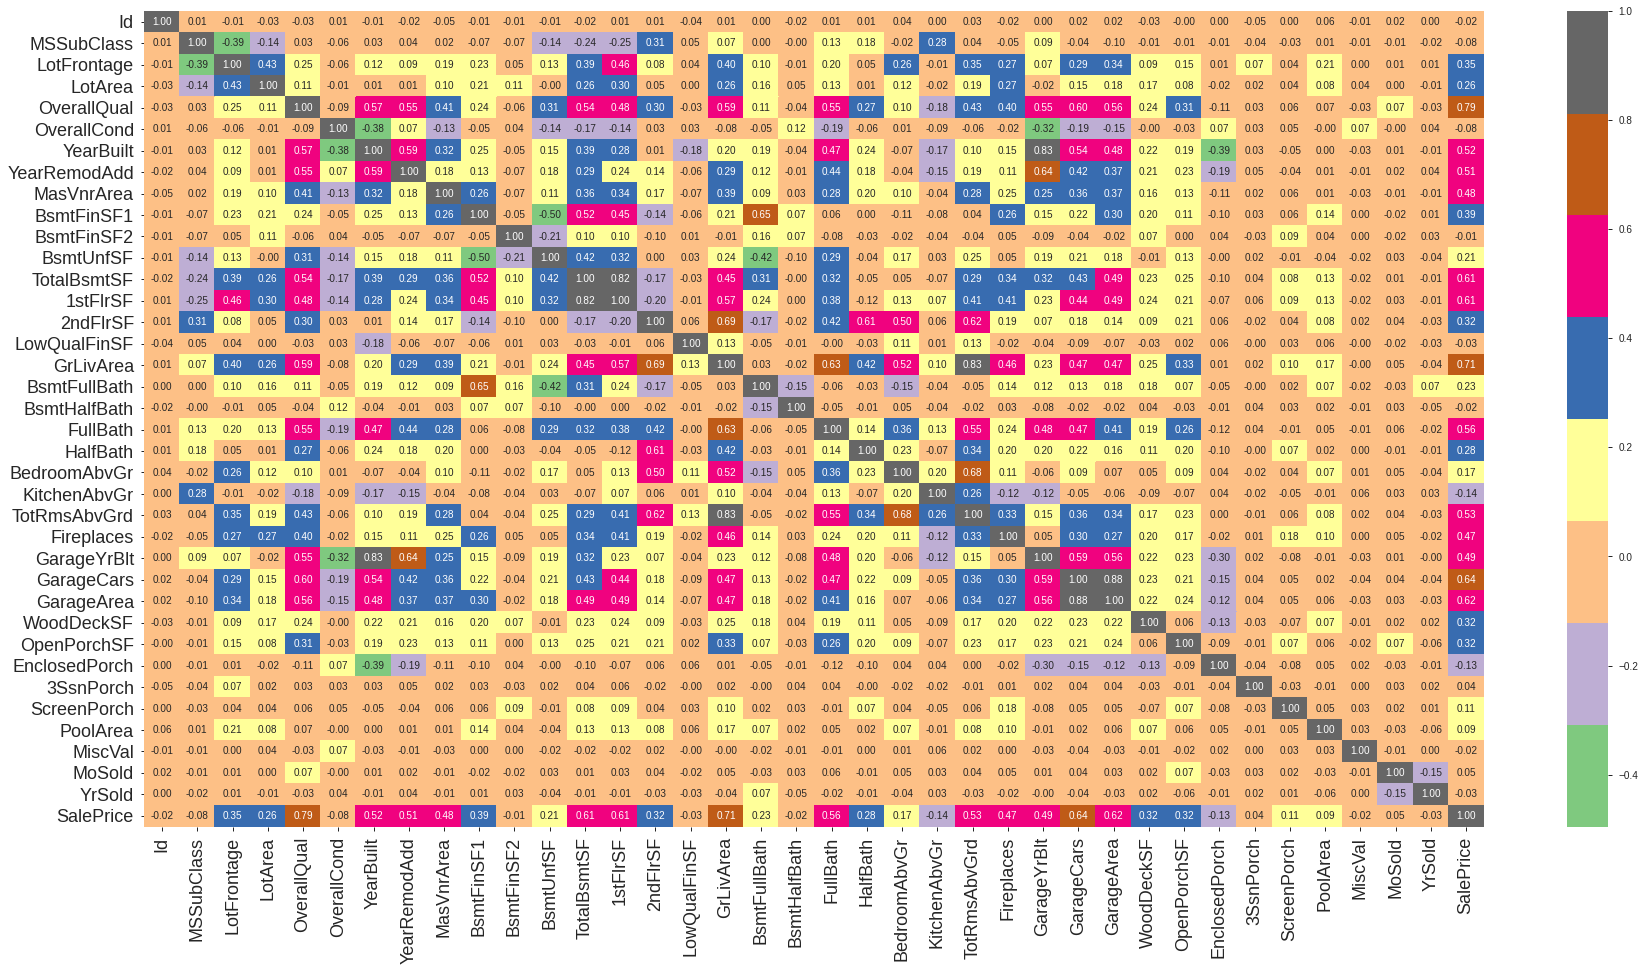

In [6]:
fig, ax = plt.subplots(figsize=(30,15))
cor = train_data.corr()
ax = sns.heatmap(cor, cmap='Accent', annot=True, fmt='.2f')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=18)
plt.show()

***NOTE: There are some cases in our data set where categories not found in the training data set, are found in the test set and vice-versal. For example, MSSubClass***

In [7]:
# Additional category in the testing set
set(test_data.MSSubClass) - set(train_data.MSSubClass)

# consider One Hot Encoding data and droping 150 column in the test set

{150}

## Feature Engineering

**Removing columns with null values greater than 1000**

In [8]:
for label, content in train_data.items():
    if content.isna().sum() > 1000:
        train_data.pop(label)
        test_data.pop(label)
        
# Dropping the Id column
train_data.pop('Id')
Id = test_data.pop('Id')

In [9]:
print(*train_data.isna().sum())

0 0 259 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 0 0 0 37 37 38 37 0 38 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 690 81 81 81 0 0 81 81 0 0 0 0 0 0 0 0 0 0 0 0 0


In [10]:
print(*test_data.isna().sum())

0 4 227 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 16 15 0 0 0 44 45 44 42 1 42 1 1 1 0 0 0 0 0 0 0 0 2 2 0 0 0 0 1 0 2 0 730 76 78 78 1 1 78 78 0 0 0 0 0 0 0 0 0 0 1 0


**Turn All object columns to numeric category**

In [11]:
# categorical features
cat_features1 = []

In [12]:
for label, content in train_data.items():
    if pd.api.types.is_string_dtype(content):
        cat_features1.append(label)
        u_train = np.unique(content.dropna())
        u_test = np.unique(test_data[label].dropna())
        if len(u_train) - len(u_test) >= 0:
            ldict = dict()
            diff = list(set(u_train) - set(u_test))
            for i, j in enumerate(u_test):
                ldict[j] = i
            else:
                l = i
                for k in diff:
                    ldict[k] = l + 1
                    l += 1
                
            train_data[label] = train_data[label].map(ldict)
            test_data[label] = test_data[label].map(ldict)

In [13]:
train_data.isna().sum().head()

MSSubClass       0
MSZoning         0
LotFrontage    259
LotArea          0
Street           0
dtype: int64

**Create first data batch and fill NaN using KNNImputer**

In [14]:
from sklearn.impute import KNNImputer

train_data1 = train_data.copy()
test_data1 = test_data.copy()

imputer = KNNImputer()
y = train_data1.SalePrice
train_data1 = pd.DataFrame(imputer.fit_transform(train_data1.drop('SalePrice', axis=1)), columns=train_data1.drop('SalePrice', axis=1).columns)
test_data1 = pd.DataFrame(imputer.transform(test_data1), columns=test_data1.columns)
train_data1['SalePrice'] = y

train_data1.head(1)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0        60.0       3.0         65.0   8450.0     1.0       3.0          3.0   

   Utilities  LotConfig  LandSlope  ...  EnclosedPorch  3SsnPorch  \
0        0.0        4.0        0.0  ...            0.0        0.0   

   ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
0          0.0       0.0      0.0     2.0  2008.0       8.0            4.0   

   SalePrice  
0     208500  

[1 rows x 76 columns]

**Filling train NaN greater < 20 with the most common of the train data**

In [15]:
for label, content in train_data.items():
    if content.isna().sum() < 20 and label != 'SalePrice':
        train_data[label] = train_data[label].fillna(list(train_data[label].mode())[0])
        test_data[label] = test_data[label].fillna(list(train_data[label].mode())[0])

In [16]:
print(*train_data.isna().sum())

0 0 259 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 37 37 38 37 0 38 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 690 81 81 81 0 0 81 81 0 0 0 0 0 0 0 0 0 0 0 0 0


In [17]:
print(*test_data.isna().sum())

0 0 227 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 44 45 44 42 0 42 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 730 76 78 78 0 0 78 78 0 0 0 0 0 0 0 0 0 0 0 0


**Create second data batch and fill the remaining NaN with KNNImputer**

In [18]:
train_data2 = train_data.copy()
test_data2 = test_data.copy()

imputer = KNNImputer()
y = train_data.SalePrice
train_data2 = pd.DataFrame(imputer.fit_transform(train_data2.drop('SalePrice', axis=1)), columns=train_data2.drop('SalePrice', axis=1).columns)
test_data2 = pd.DataFrame(imputer.transform(test_data2), columns=test_data2.columns)
train_data2['SalePrice'] = y

train_data2.head(1)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0        60.0       3.0         65.0   8450.0     1.0       3.0          3.0   

   Utilities  LotConfig  LandSlope  ...  EnclosedPorch  3SsnPorch  \
0        0.0        4.0        0.0  ...            0.0        0.0   

   ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
0          0.0       0.0      0.0     2.0  2008.0       8.0            4.0   

   SalePrice  
0     208500  

[1 rows x 76 columns]

**Create a bool feature for the missing data fields**

In [19]:
cat_features3 = cat_features1.copy()
for label, content in train_data.items():
    if content.isna().sum() > 0:
        train_data[label+'_missing'] = train_data[label].isna()
        test_data[label+'_missing'] = test_data[label].isna()
        cat_features3.append(label+'_missing')

In [20]:
train_data.head(2)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0          60         3         65.0     8450       1         3            3   
1          20         3         80.0     9600       1         3            3   

   Utilities  LotConfig  LandSlope  ...  BsmtCond_missing  \
0          0          4          0  ...             False   
1          0          2          0  ...             False   

   BsmtExposure_missing  BsmtFinType1_missing  BsmtFinType2_missing  \
0                 False                 False                 False   
1                 False                 False                 False   

   FireplaceQu_missing  GarageType_missing  GarageYrBlt_missing  \
0                 True               False                False   
1                False               False                False   

   GarageFinish_missing  GarageQual_missing  GarageCond_missing  
0                 False               False               False  
1                 False               False               False  

[2 rows x 88 columns]

**Create third data batch and Fill the remaining fields with the most common of the train data**

In [21]:
train_data3 = train_data.copy()
test_data3 = test_data.copy()

for label, content in train_data.items():
    if content.isna().sum() > 0 and label != 'SalePrice':
        train_data3[label] = train_data3[label].fillna(list(train_data3[label].mode())[0])
        test_data3[label] = test_data3[label].fillna(list(train_data3[label].mode())[0])
        
for label, content in test_data.items():
    if content.isna().sum() > 0 and label != 'SalePrice':
        train_data3[label] = train_data3[label].fillna(list(train_data3[label].mode())[0])
        test_data3[label] = test_data3[label].fillna(list(train_data3[label].mode())[0])

train_data3.head(1)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0          60         3         65.0     8450       1         3            3   

   Utilities  LotConfig  LandSlope  ...  BsmtCond_missing  \
0          0          4          0  ...             False   

   BsmtExposure_missing  BsmtFinType1_missing  BsmtFinType2_missing  \
0                 False                 False                 False   

   FireplaceQu_missing  GarageType_missing  GarageYrBlt_missing  \
0                 True               False                False   

   GarageFinish_missing  GarageQual_missing  GarageCond_missing  
0                 False               False               False  

[1 rows x 88 columns]

**Filling the remaining fields with KNNIputer**

In [22]:
imputer = KNNImputer()
y = train_data.SalePrice
train_data = pd.DataFrame(imputer.fit_transform(train_data.drop('SalePrice', axis=1)), columns=train_data3.drop('SalePrice', axis=1).columns)
test_data = pd.DataFrame(imputer.transform(test_data), columns=test_data3.columns)
train_data['SalePrice'] = y

In [23]:
print(*train_data.isna().sum())

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [24]:
print(*test_data.isna().sum())

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


**Create data batch 4**

In [25]:
train_data4 = train_data.copy()
test_data4 = test_data.copy()
train_data4.head(1)

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0        60.0       3.0         65.0   8450.0     1.0       3.0          3.0   

   Utilities  LotConfig  LandSlope  ...  BsmtExposure_missing  \
0        0.0        4.0        0.0  ...                   0.0   

   BsmtFinType1_missing  BsmtFinType2_missing  FireplaceQu_missing  \
0                   0.0                   0.0                  1.0   

   GarageType_missing  GarageYrBlt_missing  GarageFinish_missing  \
0                 0.0                  0.0                   0.0   

   GarageQual_missing  GarageCond_missing  SalePrice  
0                 0.0                 0.0     208500  

[1 rows x 88 columns]

In [26]:
# list of continious variable
contin_features = [
    'LotFrontage',
    'LotArea', 
    'YearBuilt',
    'YearRemodAdd', 
    'MasVnrArea',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'TotalBsmtSF',
    '1stFlrSF',
    '2ndFlrSF',
    'LowQualFinSF',
    'GrLivArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageYrBlt',
    'GarageCars',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'MiscVal',
    'MoSold',
    'YrSold'
]

**Creating data batch 5 by removing columns with very low variance**

In [27]:
lst = []
cat_features5 = cat_features3.copy()
for label, content in train_data.items():
    if list(content.value_counts())[0] > 1440:
        lst.append(label)
        if label in cat_features5:
            cat_features5.remove(label)
        print(label)

train_data5 = train_data.drop(lst, axis=1)
test_data5 = test_data.drop(lst, axis=1)
train_data5.columns

Street
Utilities
Condition2
PoolArea


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3S

### Preprocessed Data

In [28]:
train_data_base = (train_data1,train_data2,train_data3,train_data4,train_data5)
test_data_base = (test_data1,test_data2,test_data3,test_data4,test_data5)

In [29]:
# Number of missing data in each data batch
for data in train_data_base:
    print(np.sum(list(data.isna().sum())))
    

0
0
0
0
0


In [30]:
# Making sure data categories are of type int.

# Train data
for label, content in train_data.items():
    if pd.api.types.is_float_dtype(content):
        if label in cat_features3:
            for i in range(5):
                if label in train_data_base[i].columns:
                    train_data_base[i][label] = train_data_base[i][label].astype(int)
                    print(label)

# Test data
for label, content in test_data.items():
    if pd.api.types.is_float_dtype(content):
        if label in cat_features3:
            for i in range(5):
                if label in test_data_base[i].columns:
                    test_data_base[i][label] = test_data_base[i][label].astype(int)
                    print(label)

MSZoning
MSZoning
MSZoning
MSZoning
MSZoning
Street
Street
Street
Street
LotShape
LotShape
LotShape
LotShape
LotShape
LandContour
LandContour
LandContour
LandContour
LandContour
Utilities
Utilities
Utilities
Utilities
LotConfig
LotConfig
LotConfig
LotConfig
LotConfig
LandSlope
LandSlope
LandSlope
LandSlope
LandSlope
Neighborhood
Neighborhood
Neighborhood
Neighborhood
Neighborhood
Condition1
Condition1
Condition1
Condition1
Condition1
Condition2
Condition2
Condition2
Condition2
BldgType
BldgType
BldgType
BldgType
BldgType
HouseStyle
HouseStyle
HouseStyle
HouseStyle
HouseStyle
RoofStyle
RoofStyle
RoofStyle
RoofStyle
RoofStyle
RoofMatl
RoofMatl
RoofMatl
RoofMatl
RoofMatl
Exterior1st
Exterior1st
Exterior1st
Exterior1st
Exterior1st
Exterior2nd
Exterior2nd
Exterior2nd
Exterior2nd
Exterior2nd
MasVnrType
MasVnrType
MasVnrType
MasVnrType
MasVnrType
ExterQual
ExterQual
ExterQual
ExterQual
ExterQual
ExterCond
ExterCond
ExterCond
ExterCond
ExterCond
Foundation
Foundation
Foundation
Foundation
Foun

### Fitting catboost model to data 1

In [31]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [32]:
np.random.seed(42)
# Split data into train and test set
batch = 1
fX = train_data_base[batch-1].drop('SalePrice', axis=1)
fy = train_data_base[batch-1].SalePrice
fX_train, fX_valid, fy_train, fy_valid = train_test_split(fX, fy, test_size=0.2)
fmodel = CatBoostRegressor(eval_metric='RMSE', iterations=10000, learning_rate=0.01,
                           cat_features=cat_features1, verbose=1000, od_type='Iter', od_wait=500)
fmodel.fit(fX_train, fy_train,
         eval_set=(fX_valid, fy_valid),
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76746.0431260	test: 87114.8415853	best: 87114.8415853 (0)	total: 91.6ms	remaining: 15m 15s
1000:	learn: 16250.6169824	test: 27251.2550411	best: 27251.2550411 (1000)	total: 29.6s	remaining: 4m 26s
2000:	learn: 11796.0503034	test: 26288.6938942	best: 26288.6938942 (2000)	total: 1m 3s	remaining: 4m 14s
3000:	learn: 9401.7672640	test: 26036.8888577	best: 26036.7589553 (2998)	total: 1m 45s	remaining: 4m 5s
4000:	learn: 7930.5731543	test: 25913.8621548	best: 25913.8621548 (4000)	total: 2m 30s	remaining: 3m 45s
5000:	learn: 6758.4142940	test: 25833.2844155	best: 25831.8605213 (4987)	total: 3m 19s	remaining: 3m 18s
6000:	learn: 5879.6869359	test: 25774.9071696	best: 25774.8218327 (5998)	total: 4m 8s	remaining: 2m 45s
7000:	learn: 5172.5198092	test: 25706.4595114	best: 25705.3292619 (6997)	total: 5m	remaining: 2m 8s
8000:	learn: 4588.6900746	test: 25674.7180840	best: 25674.5715057 (7999)	total: 5m 55s	remaining: 1m 28s
9000:	learn: 4105.2685433	test: 25651.8440465	best: 25650.5128704 

### Fitting catboost model to data 2

In [33]:
np.random.seed(42)
# Split data into train and test set
batch = 2
eX = train_data_base[batch-1].drop('SalePrice', axis=1)
ey = train_data_base[batch-1].SalePrice
eX_train, eX_valid, ey_train, ey_valid = train_test_split(eX, ey, test_size=0.2)
emodel = CatBoostRegressor(eval_metric='RMSE', iterations=10000, learning_rate=0.01,
                           cat_features=cat_features1, verbose=1000, od_type='Iter', od_wait=500)
emodel.fit(eX_train, ey_train,
         eval_set=(eX_valid, ey_valid),
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76746.0431260	test: 87114.8415853	best: 87114.8415853 (0)	total: 68.6ms	remaining: 11m 25s
1000:	learn: 16457.5958295	test: 26754.7441024	best: 26754.7441024 (1000)	total: 33.6s	remaining: 5m 2s
2000:	learn: 12035.7266827	test: 25814.3788139	best: 25810.5183037 (1994)	total: 1m 12s	remaining: 4m 49s
3000:	learn: 9543.9965160	test: 25462.9031907	best: 25459.1803907 (2995)	total: 1m 54s	remaining: 4m 27s
4000:	learn: 7929.3360736	test: 25288.8213892	best: 25287.5383077 (3991)	total: 2m 39s	remaining: 3m 59s
5000:	learn: 6719.3907788	test: 25233.8461564	best: 25233.3715252 (4995)	total: 3m 28s	remaining: 3m 28s
6000:	learn: 5825.3531094	test: 25205.5873581	best: 25204.6325681 (5979)	total: 4m 19s	remaining: 2m 52s
7000:	learn: 5130.7842374	test: 25185.7532899	best: 25184.1454939 (6757)	total: 5m 14s	remaining: 2m 14s
8000:	learn: 4505.4546447	test: 25172.2173758	best: 25166.3812773 (7861)	total: 6m 10s	remaining: 1m 32s
9000:	learn: 3999.6631692	test: 25157.8835728	best: 25157.1

### Fitting catboost model to data 3

In [34]:
np.random.seed(42)
# Split data into train and test set
batch = 3
dX = train_data_base[batch-1].drop('SalePrice', axis=1)
dy = train_data_base[batch-1].SalePrice
dX_train, dX_valid, dy_train, dy_valid = train_test_split(dX, dy, test_size=0.2)
dmodel = CatBoostRegressor(eval_metric='RMSE', iterations=10000, learning_rate=0.01,
                           cat_features=cat_features3, verbose=1000, od_type='Iter', od_wait=500)
dmodel.fit(dX_train, dy_train,
         eval_set=(dX_valid, dy_valid),
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76758.6783087	test: 87116.5607845	best: 87116.5607845 (0)	total: 51ms	remaining: 8m 29s
1000:	learn: 16158.7054662	test: 26875.7729003	best: 26875.7729003 (1000)	total: 35.6s	remaining: 5m 20s
2000:	learn: 12004.5581367	test: 25858.7033894	best: 25858.7033894 (2000)	total: 1m 18s	remaining: 5m 14s
3000:	learn: 9743.0788488	test: 25540.2889522	best: 25537.9964854 (2989)	total: 2m 1s	remaining: 4m 43s
4000:	learn: 8026.4897583	test: 25344.7082144	best: 25342.0607673 (3868)	total: 2m 47s	remaining: 4m 10s
5000:	learn: 6780.4513709	test: 25289.9403913	best: 25282.5603704 (4695)	total: 3m 35s	remaining: 3m 35s
6000:	learn: 5899.7558351	test: 25226.3974031	best: 25225.4850576 (5984)	total: 4m 26s	remaining: 2m 57s
7000:	learn: 5154.5143520	test: 25196.7859327	best: 25196.7708339 (6999)	total: 5m 18s	remaining: 2m 16s
8000:	learn: 4546.6855234	test: 25167.7663304	best: 25167.5796869 (7995)	total: 6m 13s	remaining: 1m 33s
9000:	learn: 3992.2751568	test: 25151.2650023	best: 25150.9369

### Fitting catboost model to data 4

In [35]:
np.random.seed(42)
# Split data into train and test set
batch = 4
cX = train_data_base[batch-1].drop('SalePrice', axis=1)
cy = train_data_base[batch-1].SalePrice
cX_train, cX_valid, cy_train, cy_valid = train_test_split(cX, cy, test_size=0.2)
cmodel = CatBoostRegressor(eval_metric='RMSE', iterations=10000, learning_rate=0.01,
                           cat_features=cat_features3, verbose=1000, od_type='Iter', od_wait=500)
cmodel.fit(cX_train, cy_train,
         eval_set=(cX_valid, cy_valid),
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76757.5659076	test: 87117.1450386	best: 87117.1450386 (0)	total: 35.1ms	remaining: 5m 51s
1000:	learn: 16272.3338409	test: 27159.0596919	best: 27159.0596919 (1000)	total: 35.1s	remaining: 5m 15s
2000:	learn: 11856.0218496	test: 25919.7460331	best: 25919.7460331 (2000)	total: 1m 17s	remaining: 5m 7s
3000:	learn: 9583.9360150	test: 25514.2775531	best: 25510.2768786 (2982)	total: 1m 59s	remaining: 4m 38s
4000:	learn: 7885.0625849	test: 25354.0768087	best: 25353.5112297 (3971)	total: 2m 44s	remaining: 4m 6s
5000:	learn: 6686.0242177	test: 25261.1098754	best: 25260.6658816 (4994)	total: 3m 31s	remaining: 3m 31s
6000:	learn: 5759.8832797	test: 25217.1372658	best: 25215.3178808 (5960)	total: 4m 21s	remaining: 2m 54s
7000:	learn: 5001.0797783	test: 25196.9207902	best: 25196.8477409 (6999)	total: 5m 14s	remaining: 2m 14s
8000:	learn: 4420.0977375	test: 25164.5753239	best: 25163.4906789 (7952)	total: 6m 9s	remaining: 1m 32s
Stopped by overfitting detector  (500 iterations wait)

bestTe

### Fitting catboost model to data 5

In [36]:
np.random.seed(42)
# Split data into train and test set
batch = 5
bX = train_data_base[batch-1].drop('SalePrice', axis=1)
by = train_data_base[batch-1].SalePrice
bX_train, bX_valid, by_train, by_valid = train_test_split(bX, by, test_size=0.2)
bmodel = CatBoostRegressor(eval_metric='RMSE', iterations=10000, learning_rate=0.01,
                           cat_features=cat_features5, verbose=1000, od_type='Iter', od_wait=500)
bmodel.fit(bX_train, by_train,
         eval_set=(bX_valid, by_valid),
          use_best_model=True,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 76718.4529607	test: 87077.5969186	best: 87077.5969186 (0)	total: 47.5ms	remaining: 7m 54s
1000:	learn: 16184.2140507	test: 26655.2885494	best: 26655.2885494 (1000)	total: 33.7s	remaining: 5m 3s
2000:	learn: 11857.6731625	test: 25678.9277949	best: 25673.0932198 (1979)	total: 1m 12s	remaining: 4m 48s
3000:	learn: 9542.2130326	test: 25338.9248252	best: 25338.6029049 (2995)	total: 1m 53s	remaining: 4m 24s
4000:	learn: 7842.9200315	test: 25174.1329916	best: 25172.9299714 (3955)	total: 2m 37s	remaining: 3m 55s
5000:	learn: 6649.3043550	test: 25108.4793897	best: 25108.0823089 (4980)	total: 3m 26s	remaining: 3m 26s
6000:	learn: 5807.8058170	test: 25068.8470322	best: 25061.8051112 (5866)	total: 4m 16s	remaining: 2m 50s
7000:	learn: 5075.1017454	test: 25021.2637273	best: 25018.4704484 (6939)	total: 5m 8s	remaining: 2m 12s
8000:	learn: 4480.0882837	test: 25003.9717692	best: 25003.8541935 (7997)	total: 6m 3s	remaining: 1m 30s
9000:	learn: 4021.5372487	test: 24979.2698941	best: 24978.5847

## Scoring

In [37]:
# submit to kaggle csv function
def submit(y_preds, name):
    pd.DataFrame({'Id': Id, 'SalePrice': y_preds}).to_csv(f'./data/submissions/{name}', index=False)
    print(f'{name}: saved.')

In [38]:
score = lambda x, y: (mean_squared_error(np.log(x), np.log(y)))**(1/2)

**Score fmodel**

In [39]:
print('R2 Score:', fmodel.score(fX_valid,fy_valid))
y_preds = fmodel.predict(fX_valid)
print('RMSE log:', score(fy_valid, y_preds))

R2 Score: 0.9143595121885638
RMSE log: 0.1309289842803277


**Score emodel**

In [40]:
print('R2 Score:', emodel.score(eX_valid, ey_valid))
y_preds = emodel.predict(eX_valid)
print('RMSE log:', score(ey_valid, y_preds))

R2 Score: 0.9175245833422501
RMSE log: 0.12976558147425699


**Score dmodel**

In [41]:
print('R2 Score:', dmodel.score(dX_valid, dy_valid))
y_preds = dmodel.predict(dX_valid)
print('RMSE log:', score(dy_valid, y_preds))

R2 Score: 0.9176269969266022
RMSE log: 0.1323841293315642


**Score cmodel**

In [42]:
print('R2 Score:', cmodel.score(cX_valid, cy_valid))
y_preds = cmodel.predict(cX_valid)
print('RMSE log:', score(cy_valid, y_preds))

R2 Score: 0.9174613047814227
RMSE log: 0.130121098003023


**Score bmodel**

In [43]:
print('R2 Score:', bmodel.score(bX_valid, by_valid))
y_preds = bmodel.predict(bX_valid)
print('RMSE log:', score(by_valid, y_preds))

R2 Score: 0.9187757883788763
RMSE log: 0.1311076203766517


## Feature importance

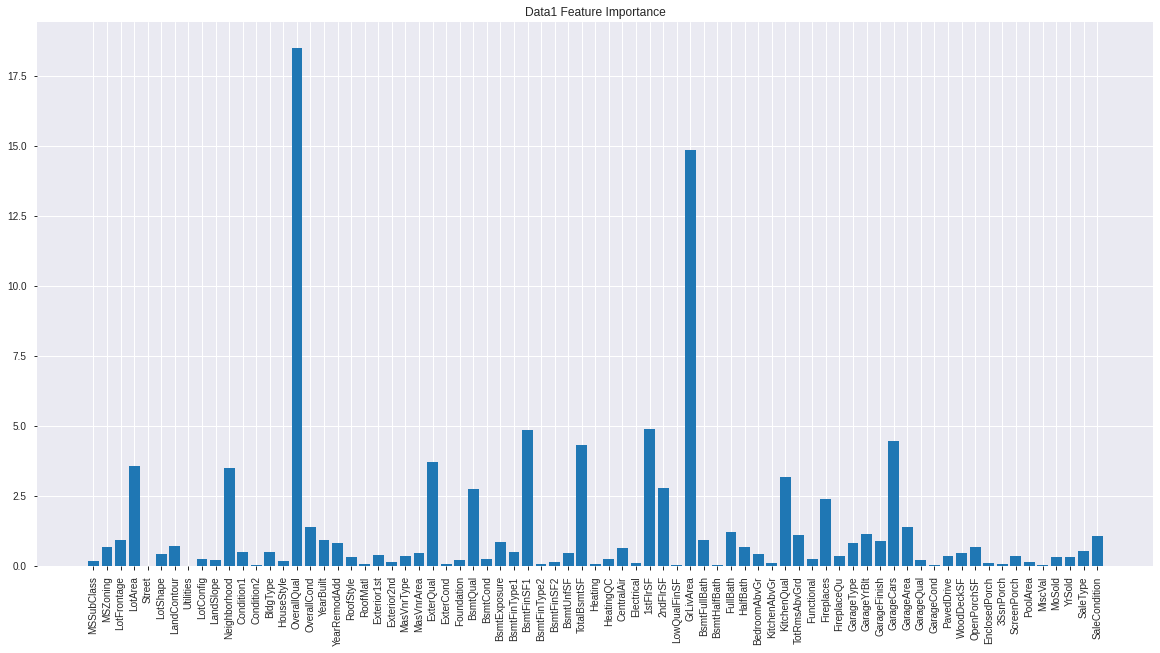

In [44]:
# Feature importance

plt.figure(figsize=(20,10))
plt.bar(fX.columns, fmodel.feature_importances_);
plt.xticks(fX.columns, rotation=90);
plt.title("Data1 Feature Importance");

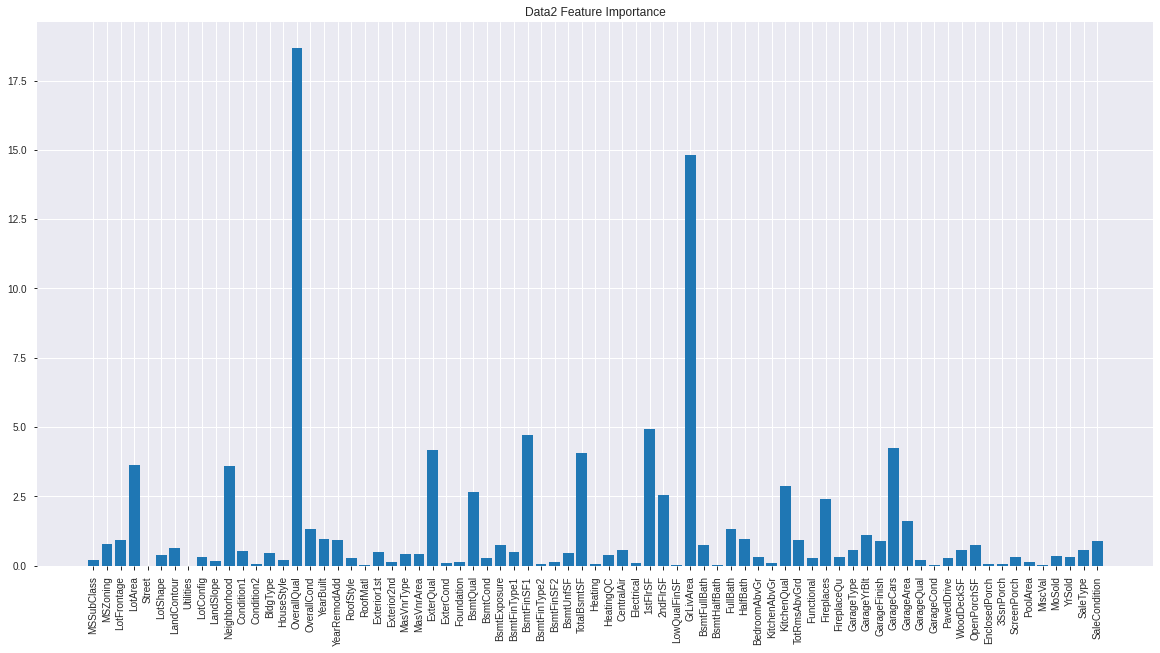

In [45]:
# Feature importance

plt.figure(figsize=(20,10))
plt.bar(eX.columns, emodel.feature_importances_);
plt.xticks(eX.columns, rotation=90);
plt.title("Data2 Feature Importance");

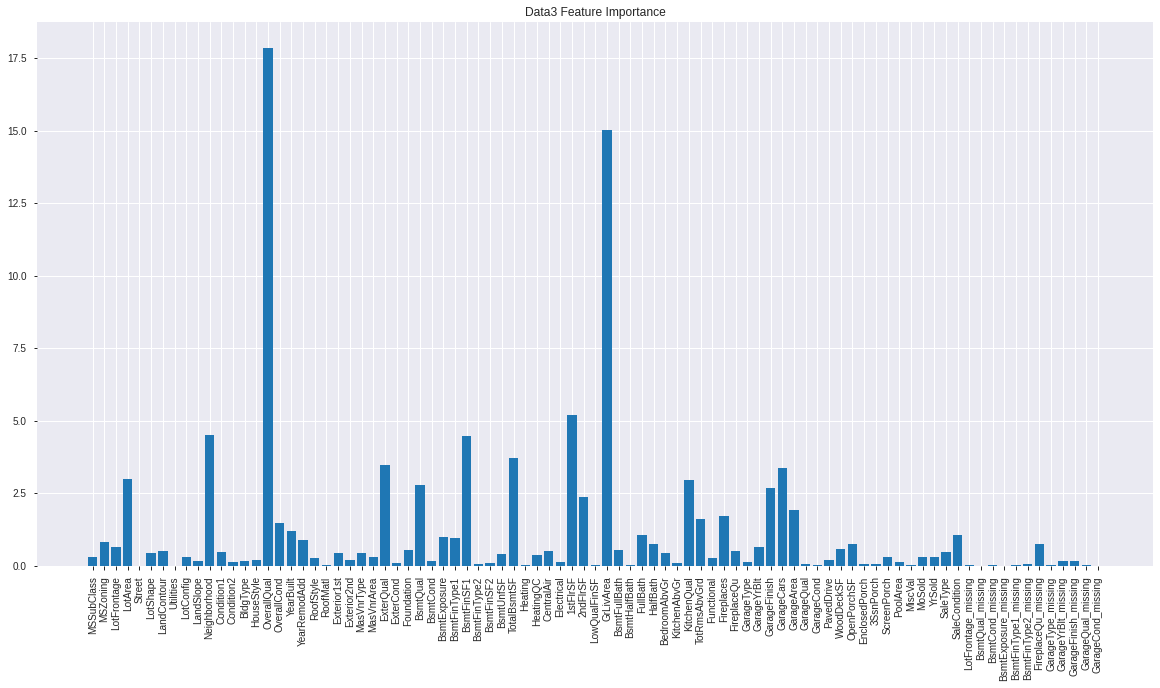

In [46]:
# Feature importance

plt.figure(figsize=(20,10))
plt.bar(dX.columns, dmodel.feature_importances_);
plt.xticks(dX.columns, rotation=90);
plt.title("Data3 Feature Importance");

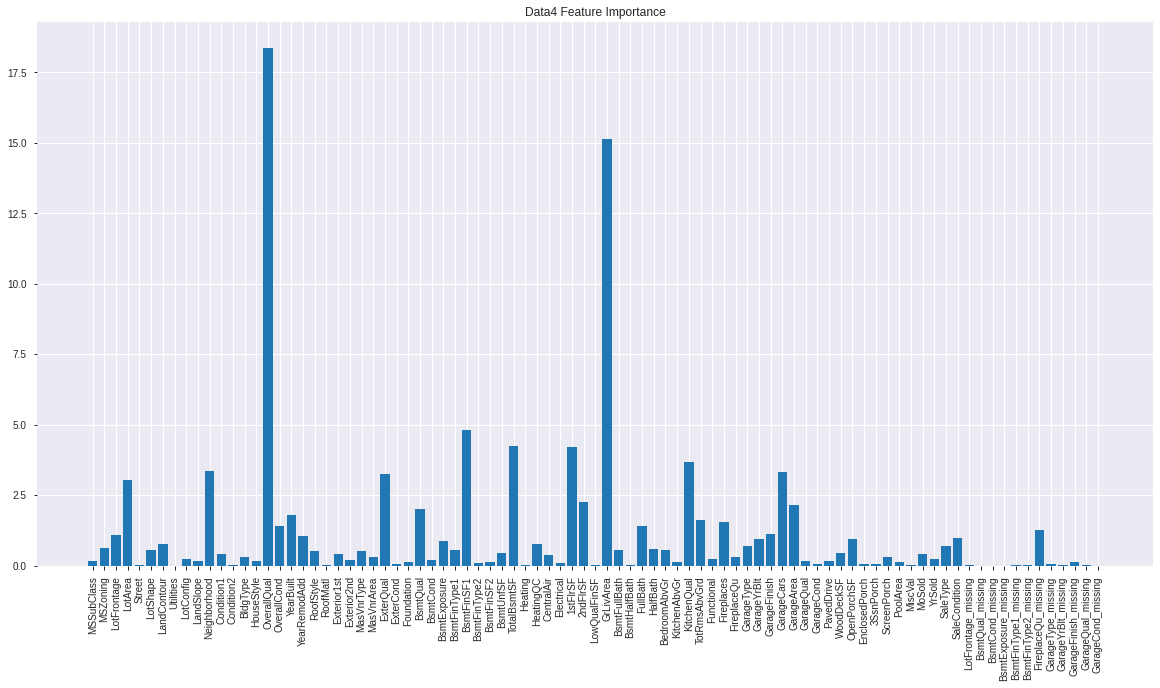

In [48]:
# Feature importance

plt.figure(figsize=(20,10))
plt.bar(cX.columns, cmodel.feature_importances_);
plt.xticks(cX.columns, rotation=90);
plt.title("Data4 Feature Importance");

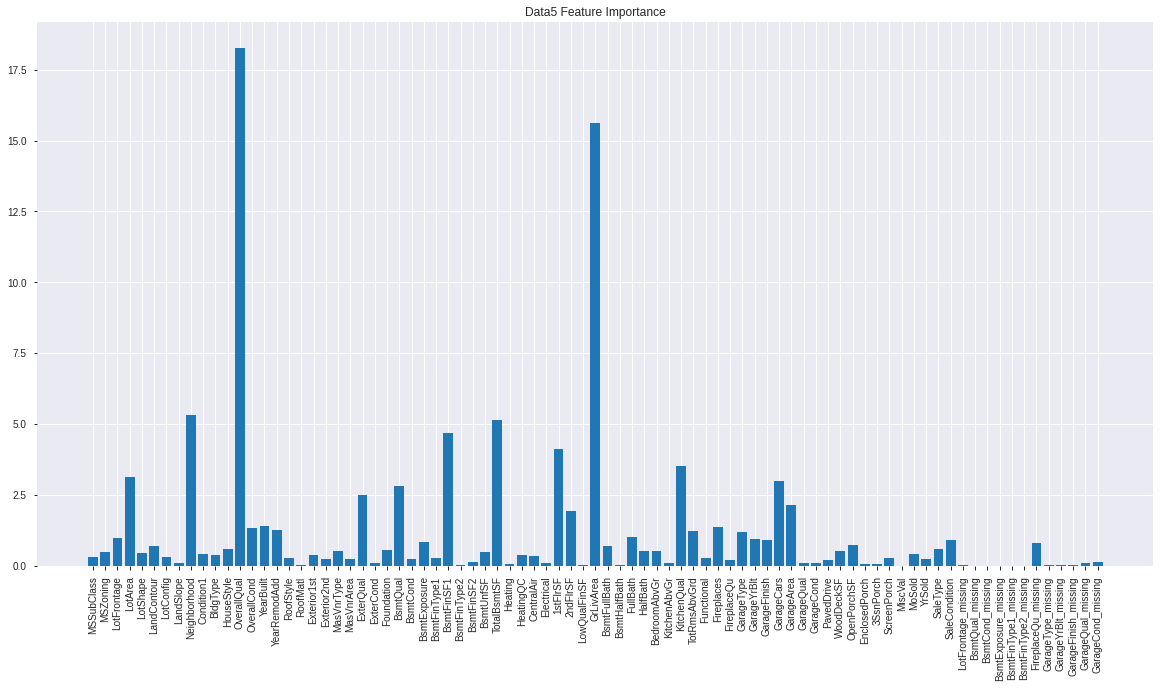

In [49]:


plt.figure(figsize=(20,10))
plt.bar(bX.columns, bmodel.feature_importances_);
plt.xticks(bX.columns, rotation=90);
plt.title("Data5 Feature Importance");

### summiting best 3 to kaggle (bmodel, cmodel and emodel)

In [51]:
# # index is batch-1
# submit(bmodel.predict(test_data_base[4]), 'bmodelPrediction.csv')
# submit(cmodel.predict(test_data_base[3]), 'cmodelPrediction.csv')
# submit(emodel.predict(test_data_base[1]), 'emodelPrediction.csv')

bmodelPrediction.csv: saved.
cmodelPrediction.csv: saved.
emodelPrediction.csv: saved.


### Saving best model

In [53]:
# import joblib
# joblib.dump(bmodel, './models/bmodel.joblib')

['./models/bmodel.joblib']